# Application: Face Blurring

In today's world, cameras and videos are everywhere and privacy has become a big concern, so much so that manual identification and annotation to preserve privacy are often not practical. In this application notebook we will demonstrate how to automatically identify faces in images using a deep learning model and then obfuscate them using various techniques to preserve privacy by obscuring the identity of the people in the images. This notebook will demonstrate various techniques using images, but this can easily be extended to videos based on the prior modules that covered video analysis. In this notebook we will use standard blurring, pixelation, and also incorporate the use of an elliptical mask to provide a better approximation to blurring the shape of a person's face.

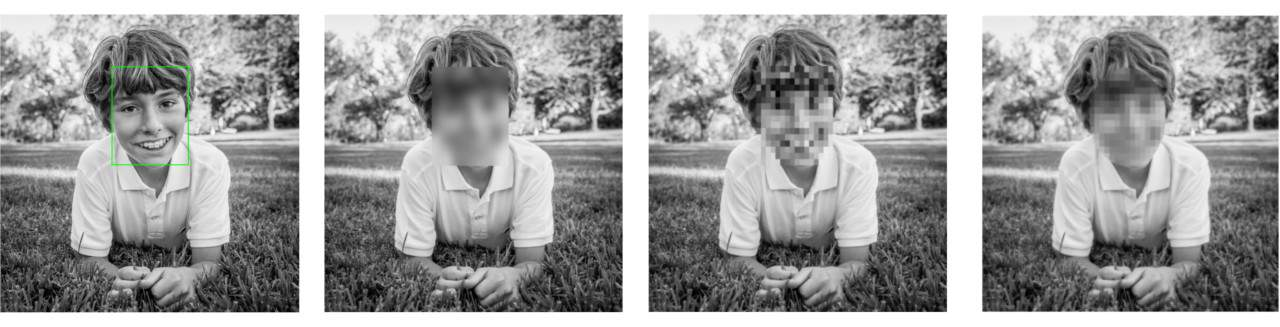

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 1. Preview Images

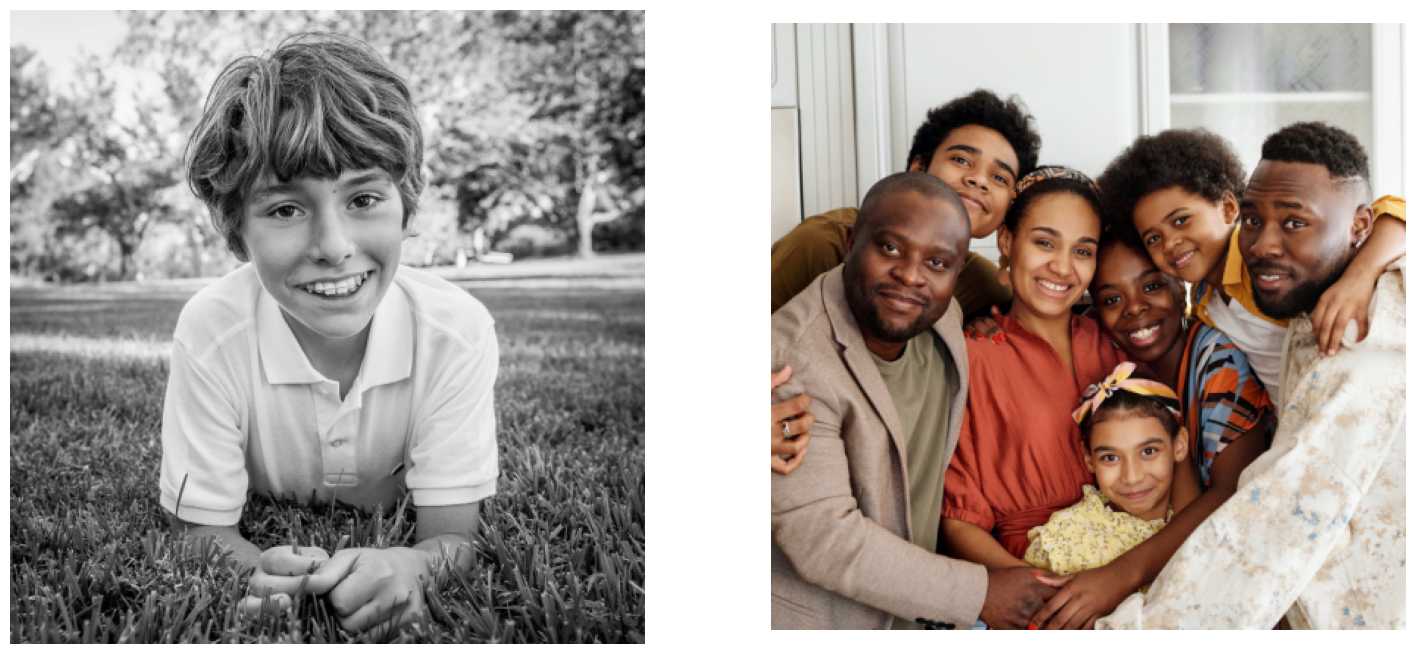

In [21]:
img1 = cv2.imread("./boy.jpg", cv2.IMREAD_COLOR)
img2 = cv2.imread("./family.jpg", cv2.IMREAD_COLOR)

fig = plt.figure(figsize=(18, 10))

plt.subplot(1, 2, 1); plt.axis("off"); plt.imshow(img1[:, :, ::-1]);
plt.subplot(1, 2, 2); plt.axis("off"); plt.imshow(img2[:, :, ::-1]);

## 2. Load the DNN Model
### Load the Face Detection Model

In [22]:
model_file = "/content/res10_300x300_ssd_iter_140000.caffemodel"
config_file = "/content/deploy.prototxt"

# Read the model and create a ntwork object
net = cv2.dnn.readNetFromCaffe(config_file, model_file)

## 3. Rectangular Face Blur
### 3.1 Defining a Blurring Function

The first technique we are going to use involves blurring the rectangular region defined by the bounding rectangle returned by the face detection model, for that we are going to define a blurring function as shown below:

In [23]:
def blur(face, factor=3):
  h, w = face.shape[:2]

  if factor < 1: factor = 1  # Maximum blurring
  if factor > 5: factor = 5  # Minimal blurring

  # Kernel size.
  w_k = int(w / factor)
  h_k = int(h / factor)

  # Insure kernel is an odd number
  if w_k % 2 == 0: w_k += 1
  if h_k % 2 == 0: h_k += 1

  blurred = cv2.GaussianBlur(face, (int(w_k), int(h_k)), 0, 0)

  return blurred

In [24]:
# Rectangular face blurr
def face_blur_rect(image, net, factor=3, detection_threshold=0.9):
  img = image.copy()
   # Conver the image into a blob format.
  blob = cv2.dnn.blobFromImage(
      img,
      scalefactor=1.0,
      size=(300, 300),
      mean=[104, 117, 123]
  )

  # Pass the blob to the DNN model.
  net.setInput(blob)

  # Retrieve detections from the DNN model.
  detections = net.forward()

  (h, w) = img.shape[:2]

  # Process the detections.
  for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > detection_threshold:
      # Extract the bounding box coordinates from the detection
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (x1, y1, x2, y2) = box.astype("int")

      # Extract the face ROI.
      face = img[y1:y2, x1:x2]
      face = blur(face, factor=factor)

      # Replace the detected face with the blurred one.
      img[y1:y2, x1:x2] = face
  return img

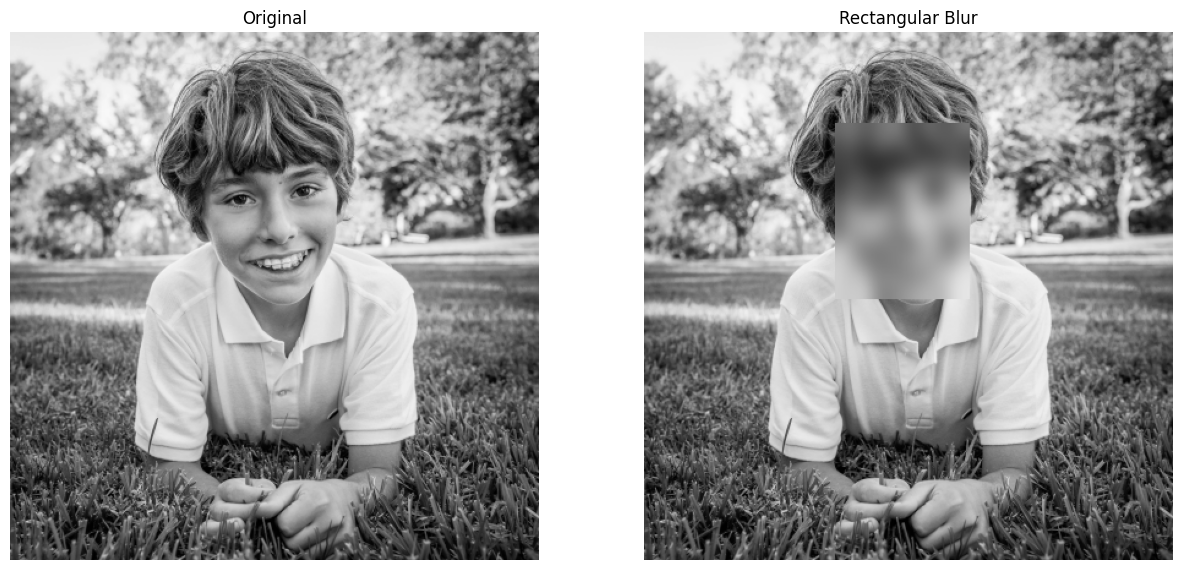

In [25]:
img1_rect = face_blur_rect(img1, net, factor=2.5)

fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(img1[:,:,::-1]);      plt.title('Original')
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(img1_rect[:,:,::-1]); plt.title('Rectangular Blur');

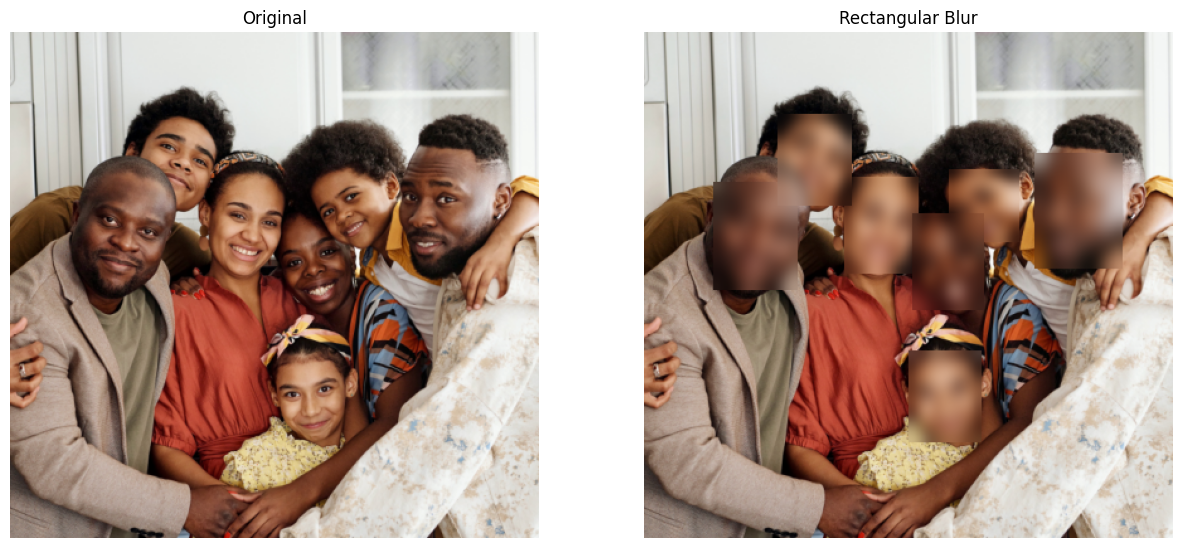

In [26]:
img2_rect = face_blur_rect(img2, net, factor=2)

fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(img2[:,:,::-1]);      plt.title('Original')
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(img2_rect[:,:,::-1]); plt.title('Rectangular Blur');

## 4. Elliptical Face Blur

In [29]:
# Elliptical face blur
def face_blur_ellipse(image, net, factor=3, detect_threshold=0.9, write_mask=False):
  img = image.copy()
  img_blur = img.copy()

  elliptical_mask = np.zeros(img.shape, dtype=img.dtype)

  # Prepare image and perform inference
  blob = cv2.dnn.blobFromImage(
      img,
      scalefactor=1.0,
      size=(300, 300),
      mean=[104, 117, 123],
  )
  net.setInput(blob)
  detections = net.forward()

  h, w = image.shape[:2]

  for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > detect_threshold:
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (x1, y1, x2, y2) = box.astype("int")

      # The face is defined by the bounding rectangle from the detection.
      face = img[y1:y2, x1:x2, :]

      # Blur the rectangular area defined by the bounding box.
      face = blur(face, factor=0)

      # Copy the `blurred_face` to the blurred image.
      img_blur[int(y1):int(y2), int(x1):int(x2), :] = face

      # Specify the elliptical parameters directly from the bounding box coordinates.
      e_center = (x1 + (x2 - x1)/2, y1 + (y2 - y1)/2)
      e_size   = (x2 - x1, y2 - y1)
      e_angle  = 0.0

      # Create an elliptical mask.
      elliptical_mask = cv2.ellipse(elliptical_mask, (e_center, (int(e_size[0]), int(e_size[1])), e_angle),
                                                      (255, 255, 255), -1, cv2.LINE_AA)
      # Apply the elliptical mask
      np.putmask(img, elliptical_mask, img_blur)

    if write_mask:
        cv2.imwrite('elliptical_mask.jpg', elliptical_mask)

    return img

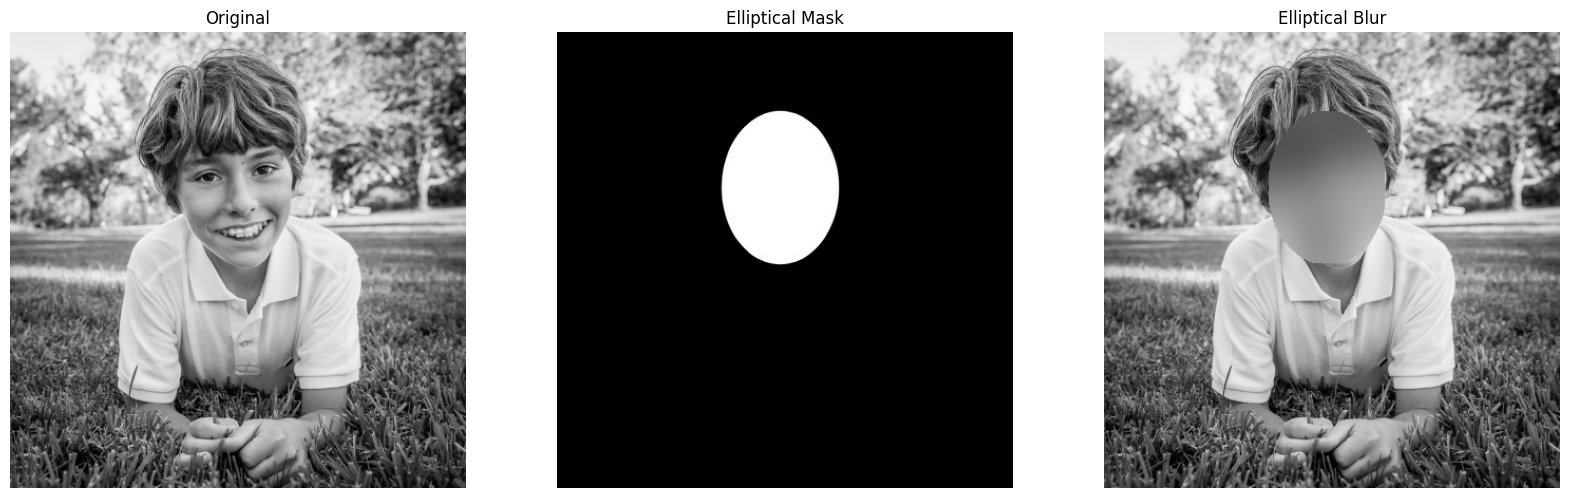

In [30]:
img1_ellipse = face_blur_ellipse(img1, net, factor=2.5, write_mask=True)

mask = cv2.imread('elliptical_mask.jpg')
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img1[:,:,::-1]);         plt.title('Original')
plt.subplot(1,3,2); plt.axis('off'); plt.imshow(mask);                   plt.title('Elliptical Mask')
plt.subplot(1,3,3); plt.axis('off'); plt.imshow(img1_ellipse[:,:,::-1]); plt.title('Elliptical Blur');

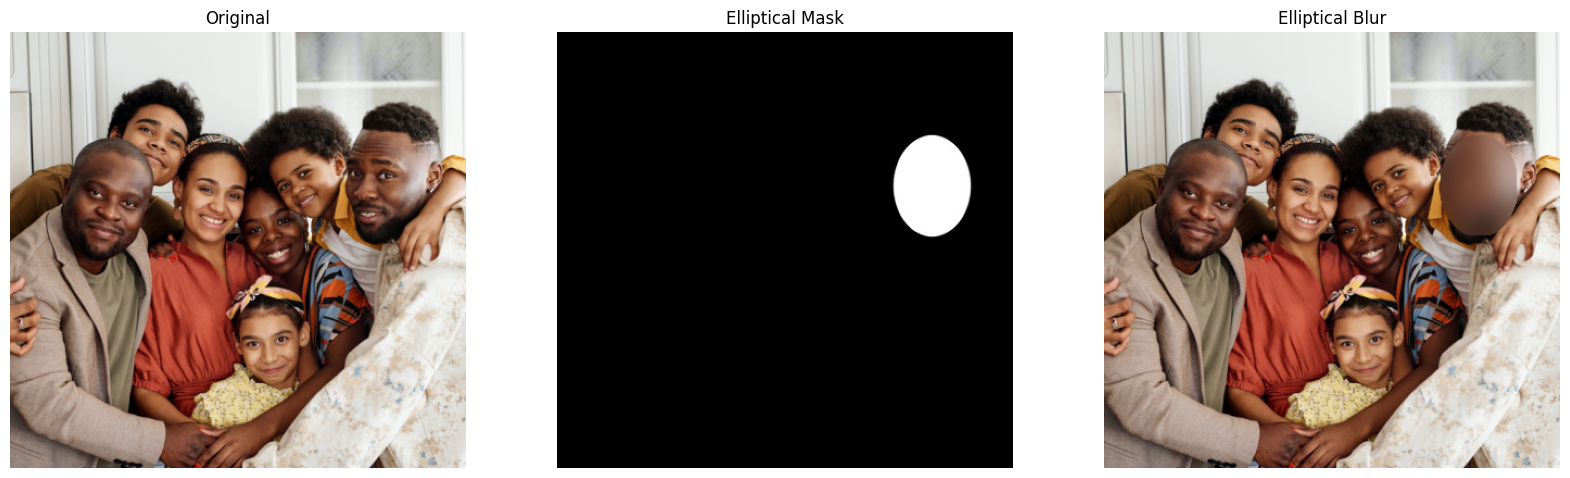

In [32]:
img2_ellipse = face_blur_ellipse(img2, net, factor=2, write_mask=True)

mask = cv2.imread('elliptical_mask.jpg')
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img2[:,:,::-1]);         plt.title('Original')
plt.subplot(1,3,2); plt.axis('off'); plt.imshow(mask);                   plt.title('Elliptical Mask')
plt.subplot(1,3,3); plt.axis('off'); plt.imshow(img2_ellipse[:,:,::-1]); plt.title('Elliptical Blur');

## 5. Pixelated Face Blur

Pixelating the detected faces can be accomplished by resizing the face at lower resolution.

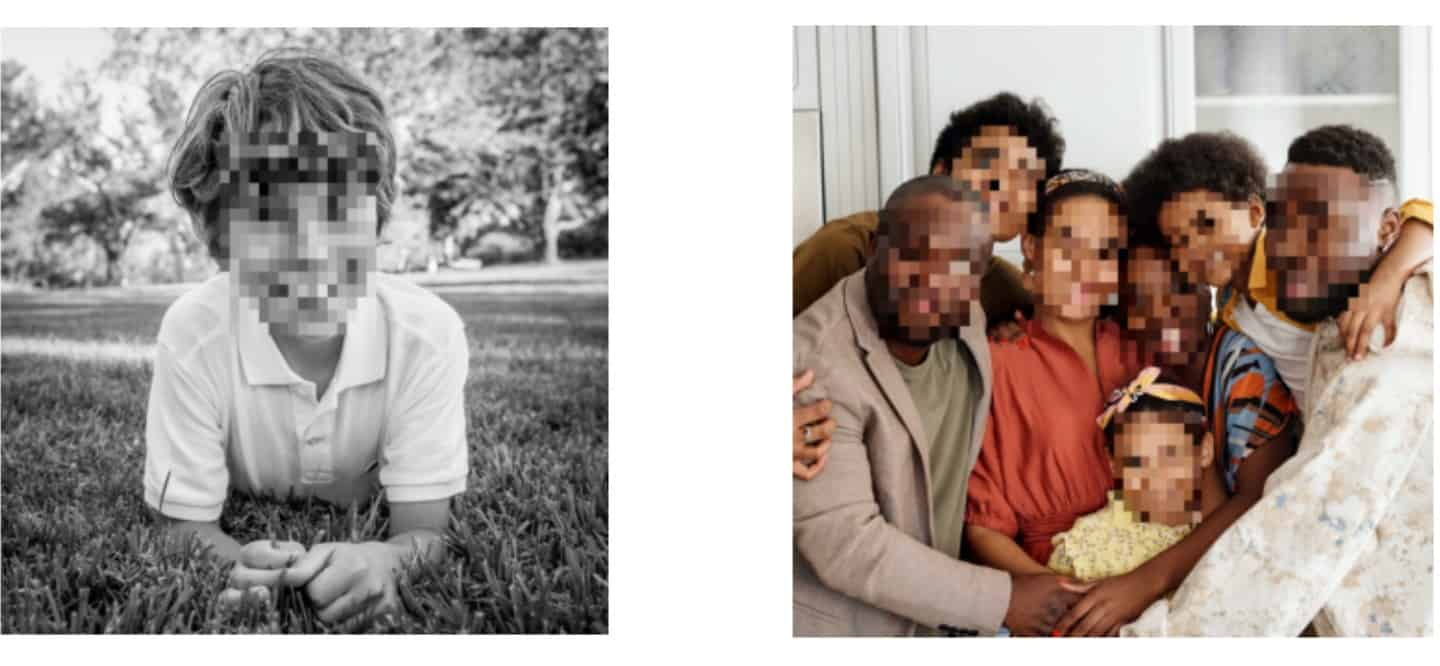

In [33]:
# Define a pixel function
def pixelate(roi, pixels=16):

    # Size of region to pixelate.
    roi_h, roi_w = roi.shape[:2]

    if roi_h > pixels and roi_w > pixels:
        # Resize input ROI to the (small) pixelated size.
        roi_small = cv2.resize(roi, (pixels, pixels), interpolation=cv2.INTER_LINEAR)

        # Now enlarge the pixelated ROI to fill the size of the original ROI.
        roi_pixelated = cv2.resize(roi_small, (roi_w, roi_h), interpolation=cv2.INTER_NEAREST)
    else:
        roi_pixelated = roi

    return roi_pixelated

In [34]:
def face_blur_pixelate(image, net, detection_threshold=0.9, pixels=10):
    img = image.copy()

    # Prepare image and perform inference.
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104, 117, 123])
    net.setInput(blob)
    detections = net.forward()

    h, w = img.shape[:2]
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detection_threshold:

            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")

            face = img[y1:y2, x1:x2]
            face = pixelate(face, pixels=pixels)
            img[y1:y2, x1:x2] = face

    return img

Text(0.5, 1.0, 'Pixelated Blur')

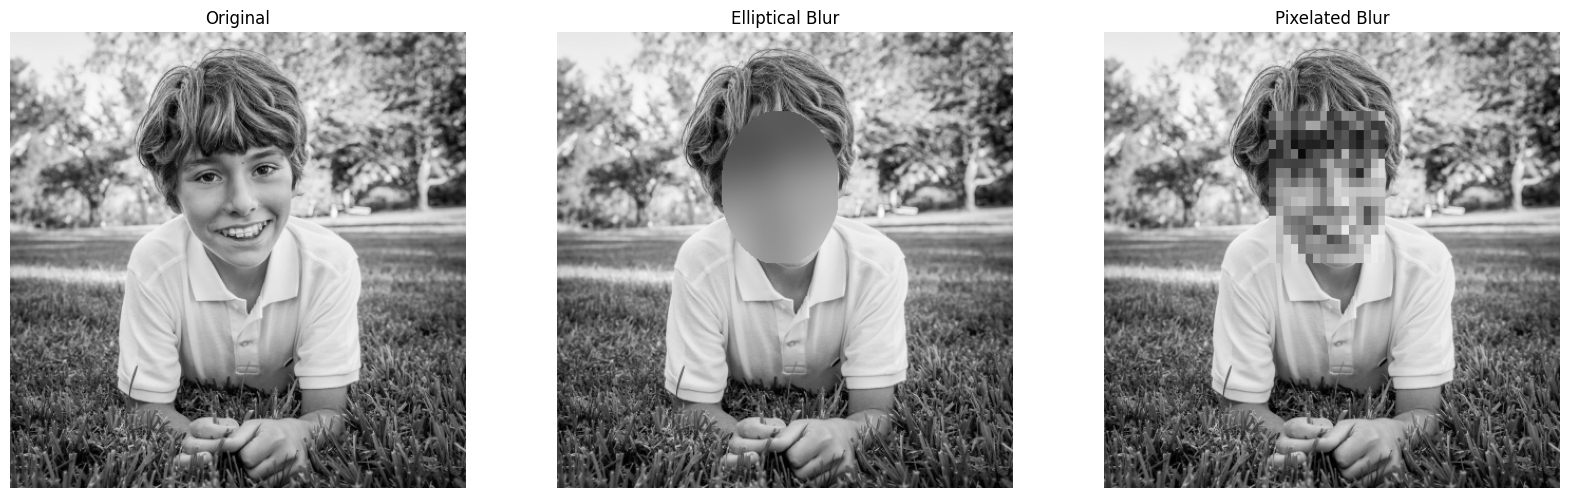

In [35]:
img1_pixel = face_blur_pixelate(img1, net, pixels=16)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img1[:,:,::-1]);         plt.title('Original')
plt.subplot(1,3,2); plt.axis('off'); plt.imshow(img1_ellipse[:,:,::-1]); plt.title('Elliptical Blur')
plt.subplot(1,3,3); plt.axis('off'); plt.imshow(img1_pixel[:,:,::-1]);   plt.title('Pixelated Blur')

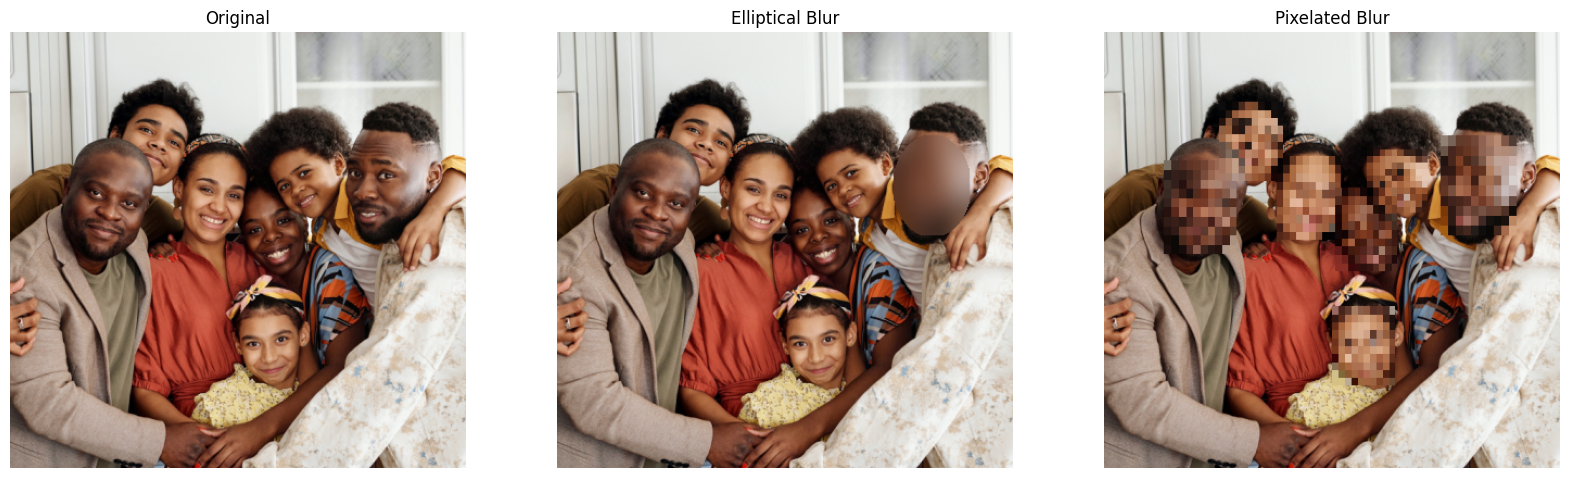

In [36]:
img2_pixel = face_blur_pixelate(img2, net, pixels=10)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img2[:,:,::-1]);         plt.title('Original')
plt.subplot(1,3,2); plt.axis('off'); plt.imshow(img2_ellipse[:,:,::-1]); plt.title('Elliptical Blur')
plt.subplot(1,3,3); plt.axis('off'); plt.imshow(img2_pixel[:,:,::-1]);   plt.title('Pixelated Blur');

## 6. Combined: Elliptical, Blurred and Pixelated

In [37]:
def face_blur_ellipse_pixelate(image, net, detect_threshold=0.9, factor=3, pixels=10, write_mask=False):

    img = image.copy()
    img_out = img.copy()
    elliptical_mask = np.zeros(img.shape, dtype=img.dtype)

    # Prepare image and perform inference.
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104, 117, 123])
    net.setInput(blob)
    detections = net.forward()

    h, w = img.shape[:2]
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detect_threshold:

            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box

            # The face is defined by the bounding rectangle from the detection.
            face = img[int(y1):int(y2), int(x1):int(x2), :]

            # Blur the rectangular area defined by the bounding box.
            face = blur(face, factor=factor)

            # Pixelate the blurred face.
            face = pixelate(face, pixels=pixels)

            # Copy the blurred/pixelated face to the output image.
            img_out[int(y1):int(y2), int(x1):int(x2), :] = face

            # Specify the elliptical parameters directly from the bounding box coordinates.
            e_center = (x1 + (x2 - x1)/2, y1 + (y2 - y1)/2)
            e_size   = (x2 - x1, y2 - y1)
            e_angle  = 0.0

            # Create an elliptical mask.
            elliptical_mask = cv2.ellipse(elliptical_mask, (e_center, e_size, e_angle),
                                                      (255, 255, 255), -1, cv2.LINE_AA)
            # Apply the elliptical mask.
            np.putmask(img, elliptical_mask, img_out)

    if write_mask:
        cv2.imwrite('elliptical_mask.jpg', elliptical_mask)

    return img

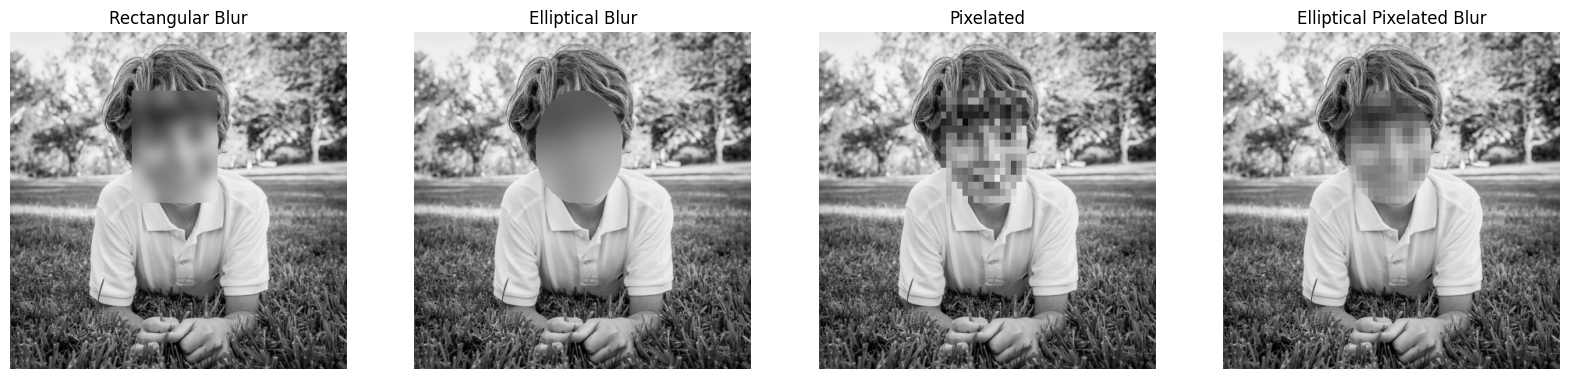

In [38]:
img1_epb = face_blur_ellipse_pixelate(img1, net, factor=3.5, pixels=15)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,4,1); plt.axis('off'); plt.imshow(img1_rect[:,:,::-1]);    plt.title('Rectangular Blur')
plt.subplot(1,4,2); plt.axis('off'); plt.imshow(img1_ellipse[:,:,::-1]); plt.title('Elliptical Blur')
plt.subplot(1,4,3); plt.axis('off'); plt.imshow(img1_pixel[:,:,::-1]);   plt.title('Pixelated')
plt.subplot(1,4,4); plt.axis('off'); plt.imshow(img1_epb[:,:,::-1]);     plt.title('Elliptical Pixelated Blur');

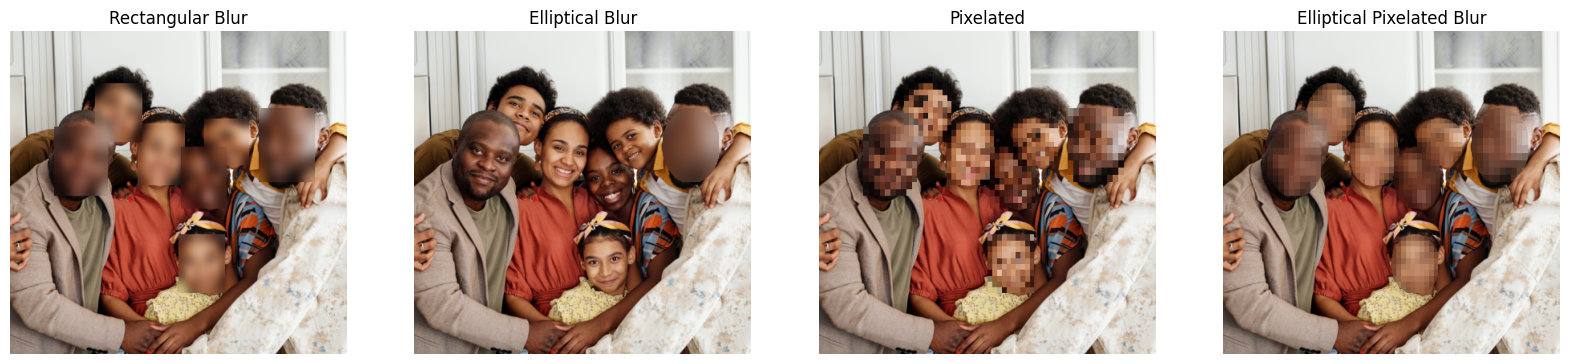

In [39]:
img2_epb = face_blur_ellipse_pixelate(img2, net, factor=2, pixels=10)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,4,1); plt.axis('off'); plt.imshow(img2_rect[:,:,::-1]);    plt.title('Rectangular Blur')
plt.subplot(1,4,2); plt.axis('off'); plt.imshow(img2_ellipse[:,:,::-1]); plt.title('Elliptical Blur')
plt.subplot(1,4,3); plt.axis('off'); plt.imshow(img2_pixel[:,:,::-1]);   plt.title('Pixelated')
plt.subplot(1,4,4); plt.axis('off'); plt.imshow(img2_epb[:,:,::-1]);     plt.title('Elliptical Pixelated Blur');